# Emotion-Recognition From Text

## 1. Importing Libraries

In [1]:
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Flatten,Embedding
from keras.utils import to_categorical


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [2]:
sns.set_theme(style="dark", context="notebook")

## 1.1 Functions for Loading and Preprocessing texts

In [3]:
def load_text(path):
    texts = []
    labels =[]
    with open(path,'r') as file:
        txts = [x.split(';') for x in file.readlines()]
        for text,label in txts:
            texts.append(text)
            labels.append(label.rstrip('\n'))
    return texts,labels

def preprocess_texts(txts):
    preprocessed_texts = []
    stop_words = set(stopwords.words('english'))
    for txt in txts:
        words = word_tokenize(txt)
        filtered_txt = [word for word in words if word.lower() not in stop_words and word not in string.punctuation]
        txt = ' '.join(filtered_txt)
        preprocessed_texts.append(txt)
    preprocessed_texts = np.array(preprocessed_texts)
    return preprocessed_texts

## 2. Loading data

In [4]:
train_texts,train_labels = load_text('/kaggle/input/emotions-dataset-for-nlp/train.txt')
val_texts,val_labels = load_text('/kaggle/input/emotions-dataset-for-nlp/val.txt')
test_texts,test_labels = load_text('/kaggle/input/emotions-dataset-for-nlp/test.txt')

## 2.1 EDA

In [5]:
print("No.of Training Examples:",len(train_texts))
print("No.of Validation Examples:",len(val_texts))
print("No.of Testing Examples:",len(test_texts))

No.of Training Examples: 16000
No.of Validation Examples: 2000
No.of Testing Examples: 2000


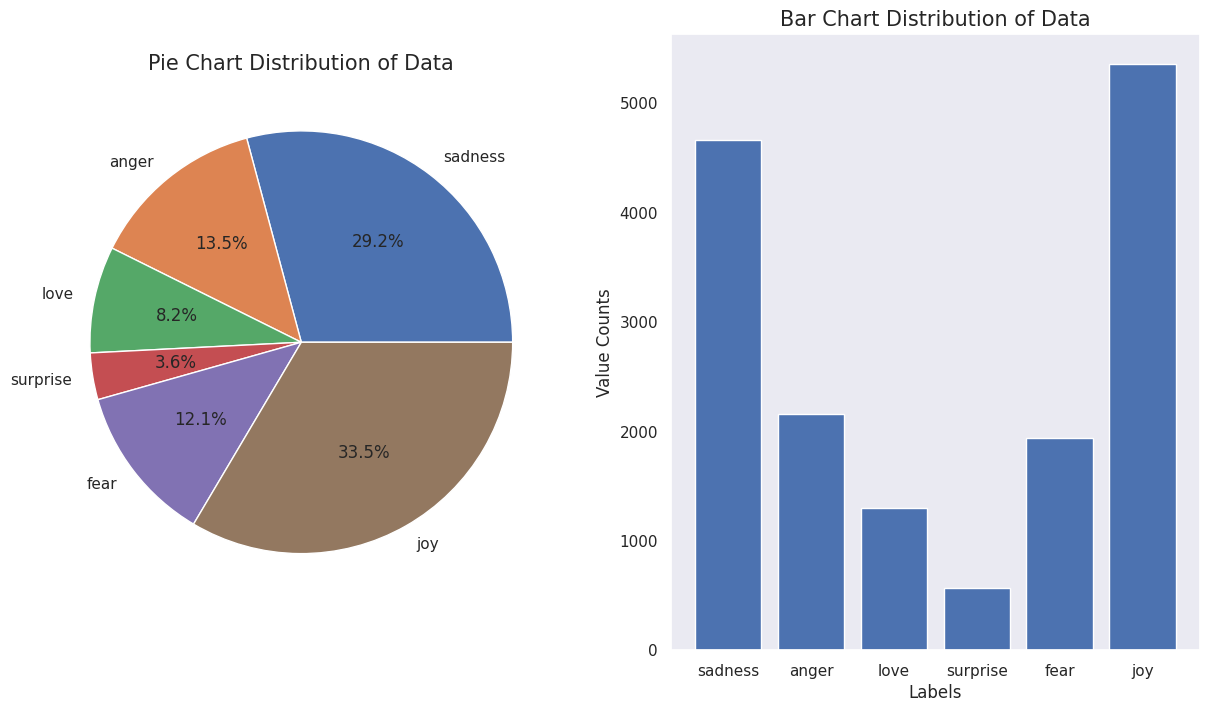

In [6]:
classes_dict = Counter(train_labels)
fig,ax = plt.subplots(1,2,figsize=(15,8))
ax[0].pie(classes_dict.values(),labels=classes_dict.keys(),autopct='%.1f%%')
ax[0].set_title("Pie Chart Distribution of Data",fontsize=15)
ax[1].bar(classes_dict.keys(),classes_dict.values())
ax[1].set_title("Bar Chart Distribution of Data",fontsize=15)
ax[1].set_xlabel("Labels")
ax[1].set_ylabel("Value Counts")
plt.show()

# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# train_labels = ["joy", "sadness", "joy", "anger", "joy", "anger", "sadness", "surprise", "fear", "love"]

# labels = list(classes_dict.keys())
# values = list(classes_dict.values())

# fig = make_subplots(
#     rows=1, cols=2, 
#     subplot_titles=("Pie Chart Distribution of Data", "Bar Chart Distribution of Data"),
#     specs=[[{'type': 'domain'}, {'type': 'xy'}]]  # Specify types: domain for pie, xy for bar
# )

# fig.add_trace(
#     go.Pie(labels=labels, values=values, hole=0.3, textinfo='label+percent'),
#     row=1, col=1
# )

# fig.add_trace(
#     go.Bar(x=labels, y=values, marker_color='indigo', text=values, textposition='outside'),
#     row=1, col=2
# )

# fig.update_layout(
#     title_text="Distribution of Data",
#     title_x=0.5,
#     showlegend=False,  # Hide legend for bar chart
#     xaxis_title="Labels",
#     yaxis_title="Value Counts",
#     yaxis=dict(titlefont=dict(size=14), tickfont=dict(size=12))
# )

# fig.show()

## 2.2 Preprocessing Text 

In [7]:
train_texts_p = preprocess_texts(train_texts)
val_texts_p = preprocess_texts(val_texts)
test_texts_p = preprocess_texts(test_texts)

## 2.3 Transforming Labels

In [8]:
enc = LabelEncoder()
train_labels_p = enc.fit_transform(train_labels)
val_labels_p = enc.fit_transform(val_labels)
test_labels_p = enc.fit_transform(test_labels)

## 2.4 Hyperparamters for tokenizing,padding and training

In [9]:
list_txts = [x.split() for x in train_texts_p]
flattened_txts = [i for j in list_txts for i in j]
num_words = len(set(flattened_txts))

maxlen = max([len(x.split()) for x in train_texts_p])

## 2.5 Tokenization and Padding

In [10]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_texts_p)

train_seqs = tokenizer.texts_to_sequences(train_texts_p)
val_seqs = tokenizer.texts_to_sequences(val_texts_p)
test_seqs = tokenizer.texts_to_sequences(test_texts_p)

train_pad = pad_sequences(train_seqs,maxlen=maxlen)
val_pad = pad_sequences(val_seqs,maxlen=maxlen)
test_pad = pad_sequences(test_seqs,maxlen=maxlen)

### 3. Building Model and Training

In [11]:
model = Sequential([Embedding(input_dim=num_words,output_dim=100),
                  LSTM(64,input_shape=(maxlen,100)),
                  Dense(6,activation='softmax')])
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
history = model.fit(train_pad,train_labels_p,epochs=8,validation_data=(val_pad,val_labels_p),shuffle=True,batch_size=16)

Epoch 1/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4379 - loss: 1.4079 - val_accuracy: 0.8470 - val_loss: 0.4458
Epoch 2/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8951 - loss: 0.3115 - val_accuracy: 0.9165 - val_loss: 0.2317
Epoch 3/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9480 - loss: 0.1460 - val_accuracy: 0.9195 - val_loss: 0.2070
Epoch 4/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9609 - loss: 0.1038 - val_accuracy: 0.9240 - val_loss: 0.1989
Epoch 5/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9729 - loss: 0.0732 - val_accuracy: 0.9225 - val_loss: 0.2064
Epoch 6/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9776 - loss: 0.0589 - val_accuracy: 0.9295 - val_loss: 0.2081
Epoch 7/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9809 - loss: 0.0475 - val_accuracy: 0.9285 - val_loss: 0.2213
Epoch 8/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9854 - loss: 0.0381 - val_accu

## 4. Evaluation

In [13]:
loss,acc = model.evaluate(test_pad,test_labels_p)

predictions =model.predict(test_pad)
predictions = np.argmax(predictions,axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9181 - loss: 0.2437
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


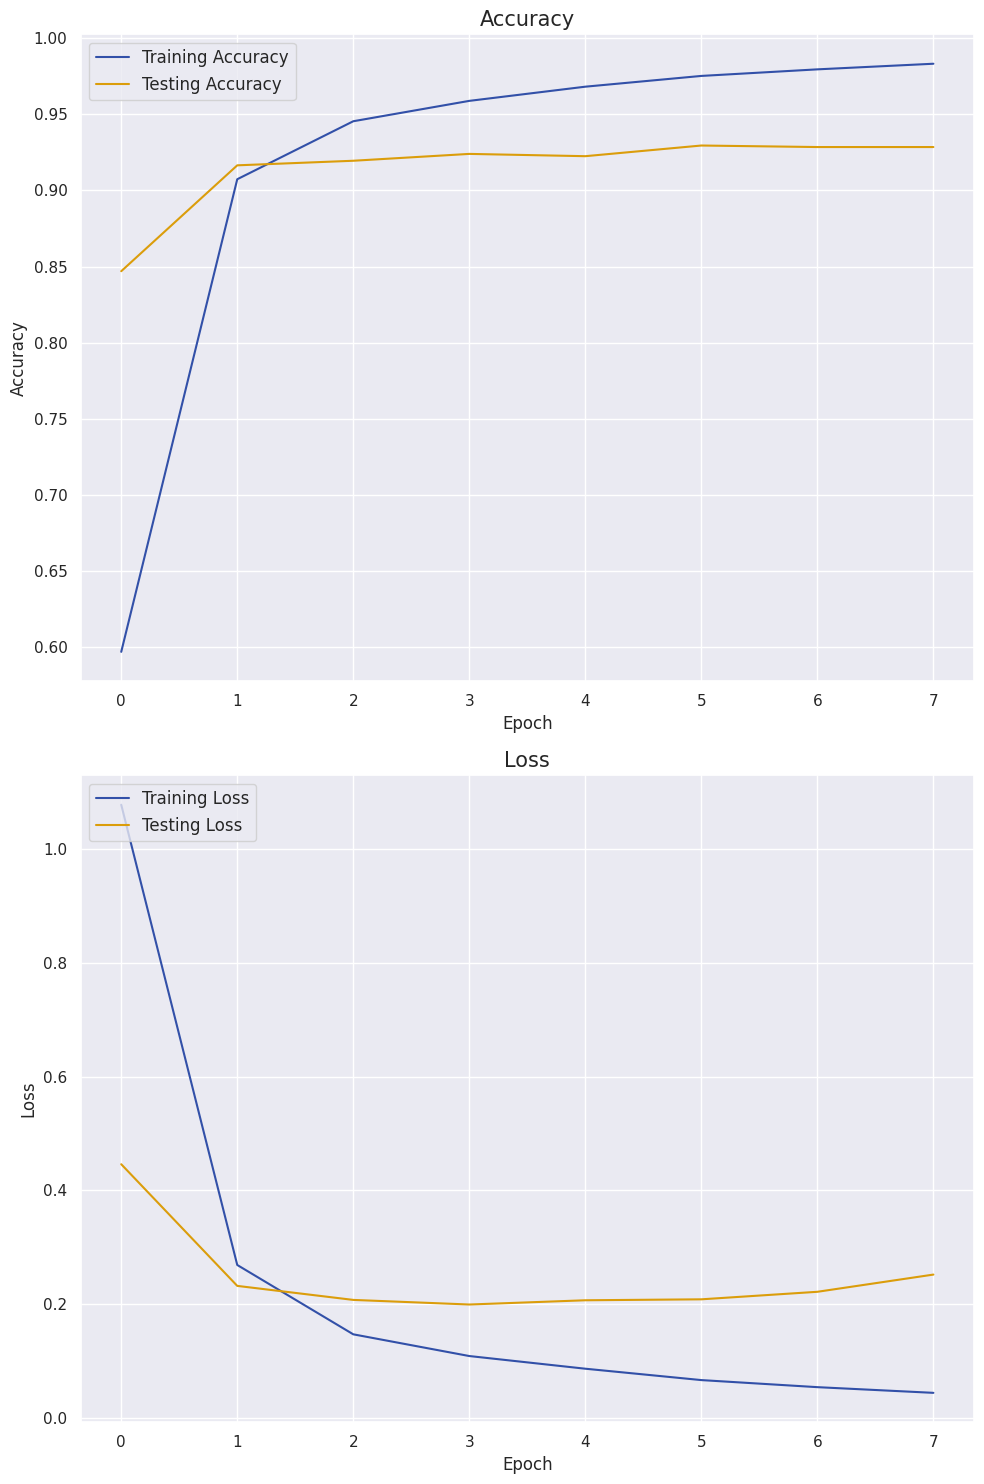

In [14]:
fig,ax = plt.subplots(2,1,figsize=(10,15))
ax[0].set_title("Accuracy",fontsize=15)                      
ax[0].plot(history.history['accuracy'],color='#3250a8',label='Training Accuracy')
ax[0].plot(history.history['val_accuracy'],color='#db9d0b',label='Testing Accuracy')
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].legend(loc="upper left", fontsize=12)
ax[0].grid(True)

ax[1].set_title("Loss",fontsize=15)                      
ax[1].plot(history.history['loss'],color='#3250a8',label='Training Loss')
ax[1].plot(history.history['val_loss'],color='#db9d0b',label='Testing Loss')
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].legend(loc="upper left", fontsize=12)
ax[1].grid(True)
plt.tight_layout()
plt.show()


<Axes: >

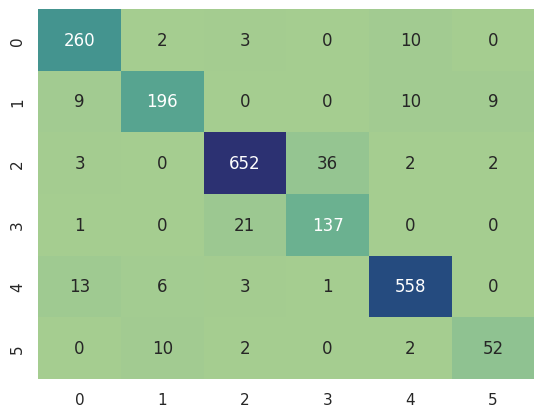

In [15]:
sns.heatmap(confusion_matrix(test_labels_p,predictions),annot=True,fmt='.0f',cbar=False,cmap='crest')

## 5. Manual Testing

In [16]:
txt = "An overwhelming emptiness fills my heart, as if the world has lost its color and the warmth has faded away."

def predict_emotion(txt):
    txt = preprocess_texts([txt])
    txt1 = tokenizer.texts_to_sequences(txt)
    txt1 = pad_sequences(txt1,maxlen=maxlen)
    pred = model.predict(txt1)
    pred = np.argmax(pred,axis=1)
    if pred == 0:
        emotion = "Anger"
    elif pred == 1:
        emotion = "Fear"
    elif pred == 2:
        emotion = "Joy"
    elif pred == 3:
        emotion = "Love"
    elif pred == 4:
        emotion = "Sadness"
    elif pred == 5:
        emotion = "Surprise"
    return emotion
predict_emotion(txt)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


'Sadness'

## 6. Saving Model and Tokenizer

In [17]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
model.save('emotion_recognizer.keras')